# 📒 Understanding the Dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('/content/names.txt', 'r').read().splitlines()

# '''
#   open('/content/names.txt', 'r') - opens the file in READ MODE and returns a FILE OBJECT (not the text itself yet).
#   .read() - reads the entire content of the file into a 'SINGLE STRING'.
#   .splitlines() - splits that big string into a list of lines (i.e., splits at every newline \n).
# '''

In [3]:
words[:9]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper']

In [4]:
type(words)

list

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set("".join(words))))   # creating vocabulary
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

### Creating the Dataset

In [7]:
block_size = 3    # context length: how many previous characters we want to consider for predicting the next word
x, y = [], []

for w in words[:4]:
  context = [0] * block_size
  print(w)
  for ch in w + '.':
    idx = stoi[ch]
    x.append(context)
    y.append(idx)
    print("".join(itos[i] for i in context), '--->', ch)
    context = context[1:] + [idx]    # crop and append

x = torch.tensor(x)
y = torch.tensor(y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .


In [8]:
x

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1]])

In [9]:
y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0])

In [10]:
x.shape, x.dtype, y.shape, y.dtype

(torch.Size([25, 3]), torch.int64, torch.Size([25]), torch.int64)

# 🗃️ PyTorch indexing is Awesome !

In [11]:
C = torch.randn((27, 2))

In [12]:
C[5]

tensor([ 0.1404, -0.0569])

In [13]:
C[[3, 4, 5]]

tensor([[ 2.3102, -0.1308],
        [-1.0459, -0.1079],
        [ 0.1404, -0.0569]])

In [14]:
C[x].shape      # embeds entire x; shape -> (no. of inputs, context window, embedding vector length)

torch.Size([25, 3, 2])

In [15]:
x[17, 2]

tensor(9)

In [16]:
C[x][17, 2]

tensor([-0.2641,  0.9783])

In [17]:
C[9]    # same same, but different INDEXING style!

tensor([-0.2641,  0.9783])

# 🔗 Creating Layers

## 1. Embedding layer

In [18]:
emb = C[x]
emb.shape

torch.Size([25, 3, 2])

## 2. Hidden layer

In [19]:
w1 = torch.randn((6, 100))    # 100 neurons in hidden layer
b1 = torch.randn((100))

emb @ w1 + b1


---------------------------------------------------------------------------
*RuntimeError                              Traceback (most recent call last)*
*<ipython-input-20-1498f270eab1> in <cell line: 0>()*
*----> 1 emb @ w1 + b1*

*RuntimeError: mat1 and mat2 shapes cannot be multiplied (75x2 and 6x100)*


### NOTE: Can't perform matrix multiplication due to unmatching dimensions

### 1. Using torch.cat()

--> inefficient as it creates new memory

In [20]:
emb.shape

torch.Size([25, 3, 2])

In [21]:
emb[:, 0, :].shape    # extracting embedding vector for 1st character of the preceding 3 characters of context

torch.Size([25, 2])

In [22]:
torch.cat([emb[:, 0, :],emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([25, 6])

performing similar operation using .unbind()

In [23]:
torch.cat(torch.unbind(emb, 1), 1).shape      # unbinding along dim=1

torch.Size([25, 6])

### 2. Using torch.view()

--> very much efficient due to PYTORCH INTERNALS

In [24]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [25]:
a.shape

torch.Size([18])

In [26]:
a.view(3, 6)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])

In [27]:
emb.view(-1, 6).shape

torch.Size([25, 6])

In [28]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)   # b1 performs broadcasting
h.shape

torch.Size([25, 100])

## 3. Final layer


In [29]:
w2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [30]:
logits = h @ w2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(25), y].log().mean()   # NLL
loss

tensor(15.1504)

In [31]:
probs[0].sum()

tensor(1.)

In [32]:
probs.shape   # (no. of examples, no. of possible chars)

torch.Size([25, 27])

# 📌 Model Summary

In [33]:
# input and target shape

x.shape, y.shape

(torch.Size([25, 3]), torch.Size([25]))

In [34]:
# parameters

g = torch.Generator().manual_seed(26451342)   # for reproducibility
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100), generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, w1, b1, w2, b2]

In [35]:
sum(p.nelement() for p in parameters)   # total no of parameters

3481

In [36]:
for p in parameters:
  p.requires_grad = True

In [37]:
for _ in range(1000):
  # forward pass
  emb = C[x]    # [25, 3, 2]
  h = torch.tanh(emb.view(-1, 6) @ w1 + b1)   # [25, 100]
  logits = h @ w2 + b2    # [25, 27]
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -probs[torch.arange(25), y].log().mean()
  loss = F.cross_entropy(logits, y)                   # we prefer this instead of the above 3 lines

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()                # computationally most heavy step
  # parameter update
  for p in parameters:
    p.data -= 0.1 * p.grad

print(loss.item())    # due to less no of examples (ie 25) and relatively large no of parameter (ie 3481), overfitting occurs for the batch of data and so the low loss

0.2254951149225235


# 🤖 Full Training

In [38]:
# Reading the full dataset
block_size = 3    # context length: how many previous characters we want to consider for predicting the next word
x, y = [], []

for w in words:
  context = [0] * block_size
  # print(w)
  for ch in w + '.':
    idx = stoi[ch]
    x.append(context)
    y.append(idx)
    # print("".join(itos[i] for i in context), '--->', ch)
    context = context[1:] + [idx]    # crop and append

x = torch.tensor(x)
y = torch.tensor(y)

In [39]:
x.shape, x.dtype, y.shape, y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [40]:
# parameters
g = torch.Generator().manual_seed(26451342)   # for reproducibility
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100), generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, w1, b1, w2, b2]

In [41]:
sum(p.nelement() for p in parameters)   # total no of parameters

3481

In [42]:
for p in parameters:
  p.requires_grad = True

## Selecting a Learning Rate

In [43]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

### Graph for selecting the LR exponent

plt.plot(lr_i, loss_i)

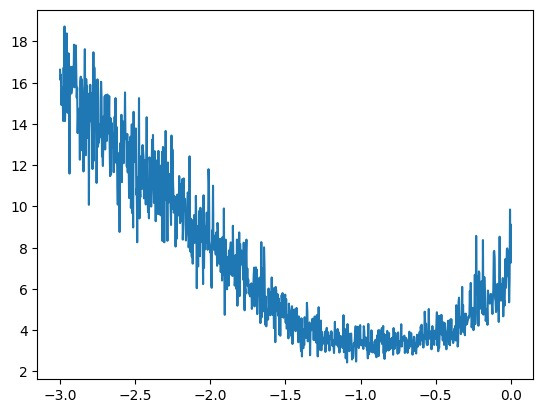

## Training in Mini-Batch

In [51]:
lr_i = []
loss_i = []

for i in range(10000):

  # constructing mini batch
  idx = torch.randint(0, x.shape[0], (32,))    # mini batch of size 32; randomly selecting 32 examples to get the approximate gradient direction and accelerate the training process

  # forward pass
  emb = C[x[idx]]    # [32, 3, 2]
  h = torch.tanh(emb.view(-1, 6) @ w1 + b1)   # [32, 100]
  logits = h @ w2 + b2    # [32, 27]
  loss = F.cross_entropy(logits, y[idx])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()                # computationally most heavy step
  # parameter update
  # lr = lrs[i]
  # lr = 0.1
  lr = 0.01                      # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # # track stats
  # lr_i.append(lre[i])
  # loss_i.append(loss.item())

print(loss.item())

2.2327191829681396


In [52]:
# loss for entire dataset
emb = C[x]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(2.3083, grad_fn=<NllLossBackward0>)

## Representing the initial embedding space

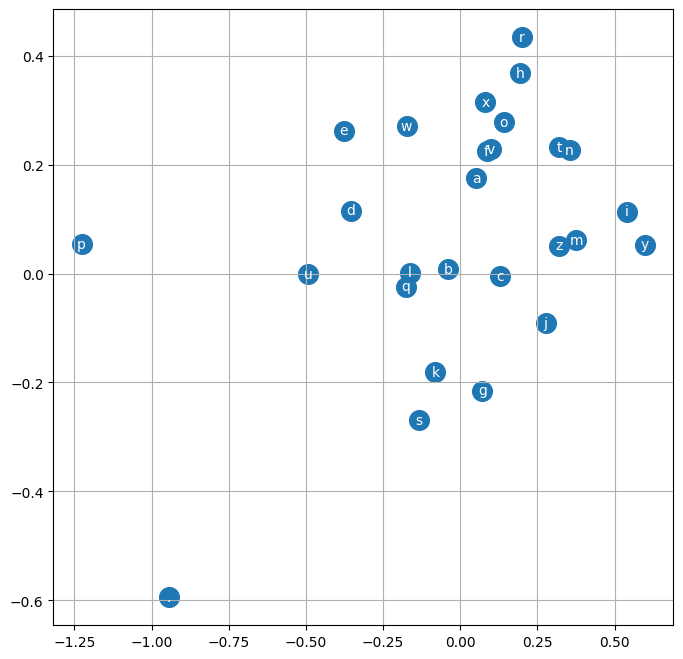

In [127]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid()

# 🪓 Dataset Split

In [85]:
# build dataset
def build_dataset(words):
  block_size = 3    # context length: how many previous characters we want to consider for predicting the next word
  x, y = [], []

  for w in words:
    context = [0] * block_size
    # print(w)
    for ch in w + '.':
      idx = stoi[ch]
      x.append(context)
      y.append(idx)
      # print("".join(itos[i] for i in context), '--->', ch)
      context = context[1:] + [idx]    # crop and append

  x = torch.tensor(x)
  y = torch.tensor(y)
  print(x.shape, y.shape)
  return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training, dev/validation, test dataset
x_tr, y_tr = build_dataset(words[:n1])
x_dev, y_dev = build_dataset(words[n1:n2])
x_tst, y_tst = build_dataset(words[n2:])

torch.Size([182661, 3]) torch.Size([182661])
torch.Size([22763, 3]) torch.Size([22763])
torch.Size([22722, 3]) torch.Size([22722])


The train and val loss were roughly the same, so it was the case of UNDER-FITTING. Possible soln are :
- scale up the NN
- remove any bottlenecks (here, size of the embedding vector might be one)

In [152]:
# parameters
g = torch.Generator().manual_seed(26451342)   # for reproducibility
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn((200), generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, w1, b1, w2, b2]

In [153]:
sum(p.nelement() for p in parameters)   # total no of parameters

11897

In [154]:
for p in parameters:
  p.requires_grad = True

In [155]:
lr_i = []
loss_i = []
steps_i = []

In [156]:
# training in mini batch
for i in range(200000):

  # constructing mini batch
  idx = torch.randint(0, x_tr.shape[0], (32,))    # mini batch of size 32; randomly selecting 32 examples to get the approximate gradient direction and accelerate the training process

  # forward pass
  emb = C[x_tr[idx]]    # [32, 3, 10]
  h = torch.tanh(emb.view(-1, 30) @ w1 + b1)   # [32, 200]
  logits = h @ w2 + b2    # [32, 27]
  loss = F.cross_entropy(logits, y_tr[idx])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()                # computationally most heavy step
  # parameter update
  # lr = lrs[i]
  # lr = 0.1
  lr = 0.1 if i < 100000 else 0.01                      # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # # track stats
  # lr_i.append(lre[i])
  loss_i.append(loss.log10().item())      # log squashed the hockey stick graph of loss
  steps_i.append(i)

print(loss.item())

2.2435147762298584


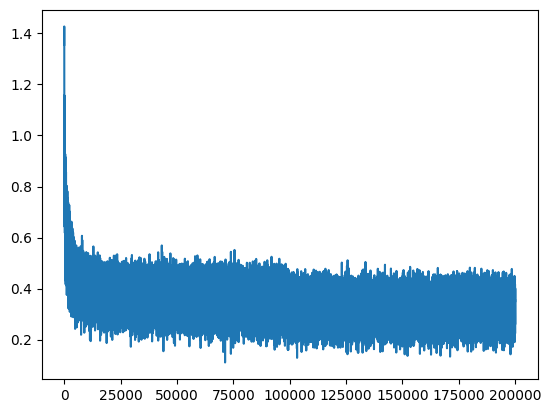

In [157]:
plt.plot(steps_i, loss_i)

In [158]:
# loss for entire dev dataset
emb = C[x_dev]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.1463, grad_fn=<NllLossBackward0>)

In [159]:
# loss for entire train dataset
emb = C[x_tr]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_tr)
loss

tensor(2.1178, grad_fn=<NllLossBackward0>)

# 😄 Generating Names

In [178]:
g = torch.Generator().manual_seed(26451344 + 93)

for i in range(20):
  context = [0] * block_size
  out = []

  while True:
    emb = C[context]      # [1, block_size, 10]
    h = torch.tanh(emb.view(1, -1) @ w1 + b1)
    logits = h @ w2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break

  print("".join(itos[i] for i in out))

saerid.
nata.
julan.
leone.
carmane.
zoey.
habelleeshana.
tianni.
wha.
alle.
fyrich.
camiziah.
deemaniya.
allee.
kaida.
savaz.
saleena.
taiinnlladurry.
jahlej.
len.
